In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
import Levenshtein

import sys
sys.path.append('..')
from lib import *

sys.path.append('/home/amayer/dropp/zach_andreas/EpitopeDistance/epdist')
from EpitopeDistance import EpitopeDistance

from pyrepseq import *
import random

plt.style.use('../peptidome.mplstyle')

In [2]:
k = 9
selfset = set(count_kmers_proteome(human, k, clean=True))

In [3]:
# only human host
df_t = load_iedb_tcellepitopes(human_only=True)
print(df_t.shape[0])

285467


In [4]:
# only MHC I epitopes
df_t = df_t[df_t['MHC', 'Class']=='I']
print(df_t.shape[0])

83870


In [5]:
# only epitopes of length k
mask = df_t['Epitope', 'Description'].apply(len)==k
df_t = df_t[mask]
print(df_t.shape[0])

45769


In [6]:
# no host epitopes
host = 'Homo sapiens'
# can also set na=True to exclude epitopes of unknown provenance
mask = ~df_t['Epitope', 'Parent Species'].str.contains(host, na=False)
df_t = df_t[mask]
print(df_t.shape[0])

38800


In [7]:
# exclude autoimmune / allergy / cancer epitopes
mask = ~(df_t['1st in vivo Process', 'Process Type'].isin(['Occurrence of autoimmune disease', 
                                                           'Occurrence of allergy',
                                                           'Occurrence of cancer']))
df_t = df_t[mask]
print(df_t.shape[0])

36172


In [8]:
# restrict to ELISPOT assay
mask = df_t['Assay', 'Method/Technique'] == 'ELISPOT'
df_t = df_t[mask]
print(df_t.shape[0])

19935


In [9]:
# uniquify epitopes by keeping only the most frequent qualitative measure
def most_frequent(x):
    counts = x.value_counts(dropna=False)
    if len(counts):
        return counts.index[0]
    else:
        print(x, counts)
    return np.nan
d = df_t[[('Epitope', 'Description'), ('Assay', 'Positive')]].groupby(('Epitope', 'Description')).agg(most_frequent)
d = d.reset_index()
len(d)

7261

In [10]:
epd = EpitopeDistance()

In [11]:
#%timeit -t min(cdist(selfset, (d['Epitope', 'Description'][0],), metric=hamming_distance, dtype=np.float))

In [12]:
x = d['Epitope', 'Description'][0]
x

'AAAAGWQTL'

In [13]:
min(cdist(selfset, (x,), metric=epd.epitope_dist, dtype=np.float))

array([5.67347145])

In [14]:
def nndist_epd(x, reference):
    potential_neighbors = next_nearest_neighbors(x, hamming_neighbors, maxdistance=2)
    neighbors = potential_neighbors.intersection(reference)
    if len(neighbors) == 0:
        return np.nan
    return min(cdist(neighbors, (x,),
                     metric=epd.epitope_dist, dtype=np.float).flatten())

In [15]:
nndist_epd(x, selfset)

5.673471451710956

In [16]:
d['nndist'] = d['Epitope', 'Description'].apply(lambda x: nndist_epd(x, selfset))

In [17]:
def ndensity(x, reference):
    potential_neighbors = next_nearest_neighbors(x, hamming_neighbors, maxdistance=2)
    neighbors = potential_neighbors.intersection(reference)
    return len(neighbors)

In [18]:
#d['nndist'] = d['Epitope', 'Description'].apply(lambda x: ndensity(x, selfset))

d['nndist'] = d['Epitope', 'Description'].apply(lambda x: min(cdist(selfset, (x,),
                                                                    metric=epd.epitope_dist, dtype=np.float)))

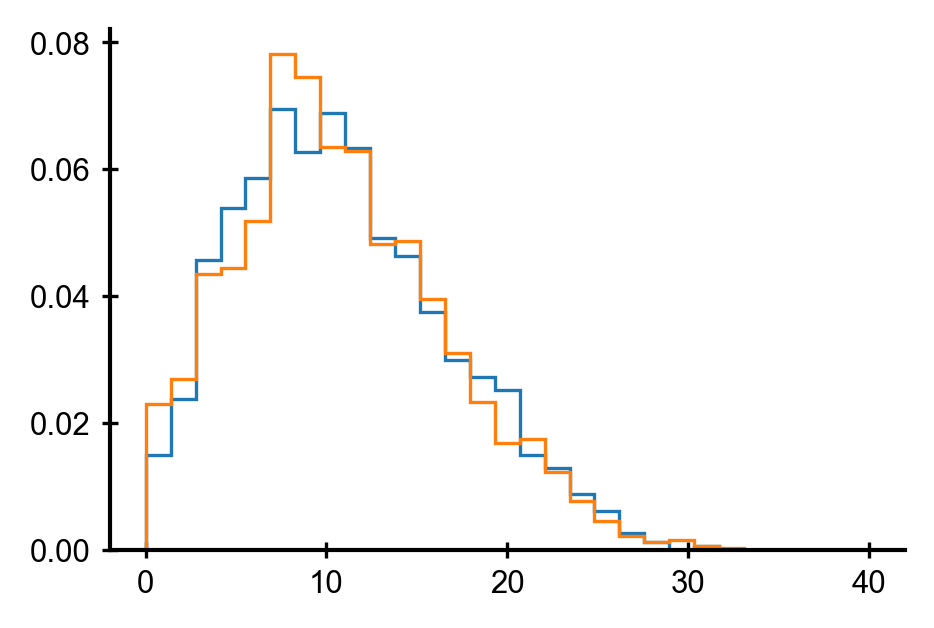

In [25]:
bins = np.linspace(0, 40, 30)
plt.hist(d[d['Assay', 'Positive']]['nndist'], bins=bins, histtype='step', density=True);
plt.hist(d[~d['Assay', 'Positive']]['nndist'], bins=bins, histtype='step', density=True);

In [33]:
d = d[d['nndist']>0]
cuts = pd.qcut(d['nndist'], 15)
dagg = d.groupby(cuts).agg(['mean', 'count'])['Assay', 'Positive']
ps = np.asarray(list(dagg['mean']))
ns = np.asarray(dagg['count'])
ps, ns

(array([0.30414747, 0.37327189, 0.37327189, 0.32258065, 0.29953917,
        0.2718894 , 0.30875576, 0.32407407, 0.32258065, 0.36866359,
        0.28571429, 0.30875576, 0.33179724, 0.37788018, 0.31797235]),
 array([217, 217, 217, 217, 217, 217, 217, 216, 217, 217, 217, 217, 217,
        217, 217]))

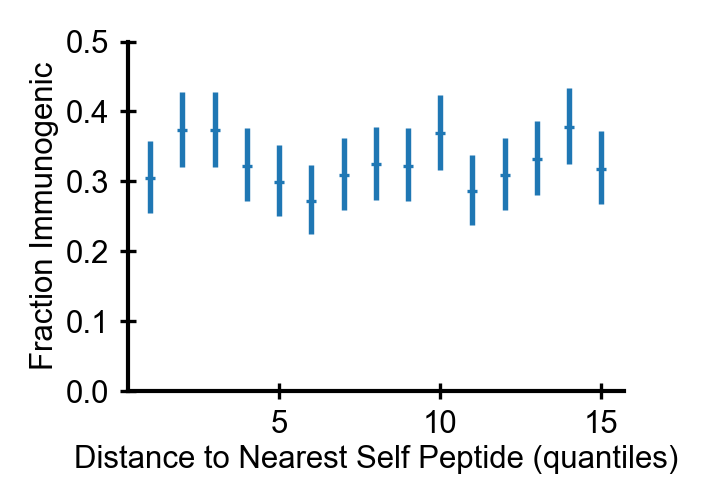

In [34]:
fig, ax = plt.subplots(figsize=(2.25, 1.75))
lower, upper = statsmodels.stats.proportion.proportion_confint(ps*ns, ns, method='jeffreys', alpha=.1)
ax.errorbar(range(1, len(ps)+1), ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0.0, 0.5)
ax.set_xlabel('Distance to Nearest Self Peptide (quantiles)')
ax.set_ylabel('Fraction Immunogenic')
fig.tight_layout()
fig.savefig(figuredir+'iedbposvscrossdist.svg')

In [124]:
test = statsmodels.stats.proportion.proportions_chisquare_allpairs(ps*ns, ns)
list(zip(test.all_pairs, test.pval_corrected()))

[((0, 1), 0.40461875254889024),
 ((0, 2), 0.8529884437464257),
 ((0, 3), 0.8529884437464257),
 ((1, 2), 0.7727905360381304),
 ((1, 3), 0.49325928104279015),
 ((2, 3), 0.8529884437464257)]

In [34]:
df_t[df_t['Epitope', 'Description'].isin(set(d[(d['nndist']==0)
     & d['Assay', 'Positive']]['Epitope', 'Description']))]

Reference  \
                                 Assay IRI   
322919   http://www.iedb.org/assay/3193385   
397160  http://www.iedb.org/assay/12566377   

                                                                       \
                                Reference IRI        Type   PubMed ID   
322919  http://www.iedb.org/reference/1031485  Literature  28148797.0   
397160  http://www.iedb.org/reference/1038020  Literature  33490292.0   

                                                                          \
                                                  Authors        Journal   
322919  Alba Grifoni; Michael Angelo; John Sidney; Sin...        J Virol   
397160  Yan Lin; Yu Dong; Yanfeng Gao; Ranran Shi; Yub...  J Immunol Res   

                                                                               \
        Date                                              Title Submission ID   
322919  2017  Patterns of Cellular Immunity Associated with ...           NaN   
397160  2021  Identification of CTL Epitopes on Efflux Pumps...           NaN   

                                   Epitope  ...  \
                               Epitope IRI  ...   
322919  http://www.iedb.org/epitope/184390  ...   
397160   http://www.iedb.org/epitope/37149  ...   

                                            Assay Antigen  \
                              Antigen Source Molecule IRI   
322919     http://www.ncbi.nlm.nih.gov/protein/ANW72071.1   
397160  http://www.ncbi.nlm.nih.gov/protein/WP_0039014...   

                                                           \
                                      Protein Parent Name   
322919                                 Genome polyprotein   
397160  Energy-dependent translational throttle protei...   

                                                                           \
                           Protein Parent IRI       Antigen Organism Name   
322919  http://www.uniprot.org/uniprot/P17763              Dengue virus 4   
397160  http://www.uniprot.org/uniprot/P9WQK3  Mycobacterium tuberculosis   

                                                        \
                                  Antigen Organism IRI   
322919  http://purl.obolibrary.org/obo/NCBITaxon_11070   
397160   http://purl.obolibrary.org/obo/NCBITaxon_1773   

                                    \
             Organism Species Name   
322919                Dengue virus   
397160  Mycobacterium tuberculosis   

                                                        \
                                  Organism Species IRI   
322919  http://purl.obolibrary.org/obo/NCBITaxon_12637   
397160   http://purl.obolibrary.org/obo/NCBITaxon_1773   

                                           Assay Comments    Assay Epitope  
                                           Assay Comments Positive  Length  
322919  The epitope was also shown previously to be re...     True       9  
397160                             ICS was also positive.     True       9  

[2 rows x 144 columns]

In [15]:
epitopes = d[d['nndist']==1]['Epitope', 'Description']

In [16]:
neighbors = []
diffposs = []
for epitope in epitopes:
    all_neighbors = set(hamming_neighbors(epitope)).intersection(selfset)
    neighbor = random.choice(list(all_neighbors))
    diffpos = int(np.where(np.array(list(epitope)) != np.array(list(neighbor)))[0])
    diffposs.append(diffpos)
    neighbors.append(neighbor)
    print(epitope,
          neighbor,
          len(all_neighbors),
          diffpos)
neighbors = np.array(neighbors)
diffposs = np.array(diffposs)

AAAPVVESK AAAKVVESK 1 3
AEFTVPKFL ADFTVPKFL 1 1
AEMLREEGY AEMIREEGY 1 3
AESRKLLLI AESRKLLLR 1 8
AKLDRLDEE AKLDNLDEE 1 4
ALDGYNGTV ALDGYNGTI 1 8
ALFASRPRF VLFASRPRF 1 0
ALIIIRSLL ARIIIRSLL 1 1
ALIRILQQL ALDRILQQL 1 2
ALIRRLQQL ALIRRLQQA 1 8
ALPQSILLF ALPRSILLF 1 3
ALQSQSISL VLQSQSISL 1 0
ALVVPVFEI ALVVPAFEI 1 5
ALYDGMEHL GLYDGMEHL 1 0
AMAGASTSA ASAGASTSA 1 1
AMASASTSA AMASASSSA 1 6
AMAVLYLAL AVAVLYLAL 1 1
AMLSKVVIL AMPSKVVIL 1 2
APGPLPRSL MPGPLPRSL 2 0
APKKKSIKL APKKKSIKS 1 8
APVPPPEPL APVVPPEPL 1 3
AYLEAIHDF AYLEAIHNF 1 7
AYLEAIHKF AYLEAIHNF 1 7
AYLEAIHYF AYLEAIHNF 1 7
CLYDGMEHL GLYDGMEHL 1 0
CTELKLSDN VTELKLSDN 1 0
CYNPRTNKW CYNPRTNEW 2 7
DEQIESMTY DEQMESMTY 1 3
DESTLSPEM DESTLSPEE 1 8
DIDSAIETY DIDAAIETY 1 3
DLKPDNILL DLKPDNILI 10 8
DLQDRNTEL DLQDRNDEL 1 6
DLYDGMEHL GLYDGMEHL 1 0
DMKARQKAL DMKARQEAL 1 6
DRFYKVLRA DRFYKVLTA 1 7
DYVSALHPV DHVSALHPV 1 1
EEAIVAYTL EEAPVAYTL 1 3
EEEEDGESL EEEEDGESE 4 8
EEFWLVDLL EEFRLVDLL 1 3
EEKSDINTL EEKSDIETL 1 6
EELKQKLRL EEQKQKLRL 1 2
EELSATVPS EEPSA

In [17]:
df_d1 = d[d['nndist']==1]
df_d1['Position difference'] = diffposs

/home/amayer/miniconda3/envs/min/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/amayer/miniconda3/envs/min/lib/python3.6/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


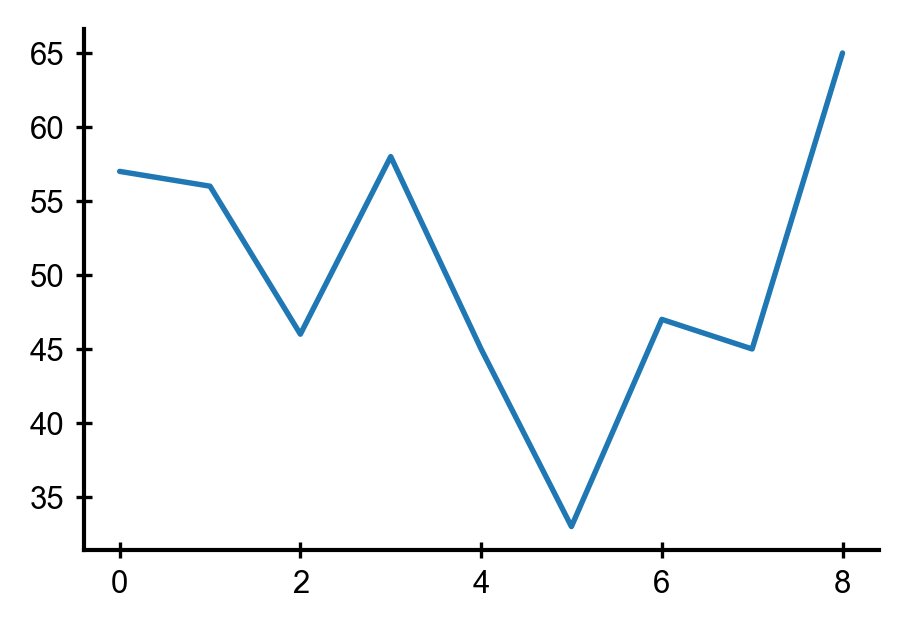

In [18]:
plt.plot(df_d1.groupby('Position difference').agg('count')['Epitope', 'Description'])

(0.0, 1.0)

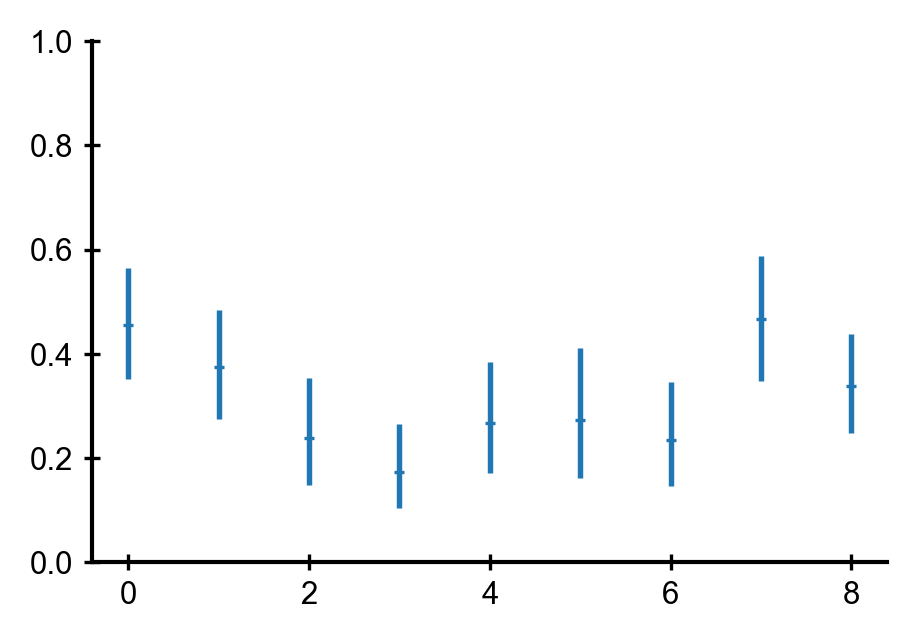

In [19]:
ps = df_d1.groupby('Position difference').agg('mean')['Assay', 'Positive']
ns = df_d1.groupby('Position difference').agg('count')['Assay', 'Positive']
lower, upper = statsmodels.stats.proportion.proportion_confint(ps*ns, ns, method='jeffreys', alpha=.1)
fig, ax = plt.subplots()
ax.errorbar(range(len(ps)), ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0, 1)

In [20]:
test = statsmodels.stats.proportion.proportions_chisquare_allpairs(ps*ns, ns)
list(zip(test.all_pairs, test.pval_corrected()))

[((0, 1), 0.9980656847646582),
 ((0, 2), 0.5058282475958678),
 ((0, 3), 0.036640111394350194),
 ((0, 4), 0.7550113952549563),
 ((0, 5), 0.8927461047525793),
 ((0, 6), 0.46083077063465594),
 ((0, 7), 0.9998768375771219),
 ((0, 8), 0.9861429846945482),
 ((1, 2), 0.9697903612444139),
 ((1, 3), 0.40364544185140694),
 ((1, 4), 0.9954390335056164),
 ((1, 5), 0.9971990996799104),
 ((1, 6), 0.9578736182369837),
 ((1, 7), 0.9977417866882642),
 ((1, 8), 0.9998768375771219),
 ((2, 3), 0.9980656847646582),
 ((2, 4), 0.9998768375771219),
 ((2, 5), 0.9998768375771219),
 ((2, 6), 0.9998768375771219),
 ((2, 7), 0.5058282475958678),
 ((2, 8), 0.9954390335056164),
 ((3, 4), 0.9954390335056164),
 ((3, 5), 0.9954390335056164),
 ((3, 6), 0.9980656847646582),
 ((3, 7), 0.042524476143140255),
 ((3, 8), 0.6561030477934815),
 ((4, 5), 0.9998768375771219),
 ((4, 6), 0.9998768375771219),
 ((4, 7), 0.7550113952549563),
 ((4, 8), 0.9980656847646582),
 ((5, 6), 0.9998768375771219),
 ((5, 7), 0.8917790570046658),
 (

# Epitope Distance

In [21]:
sys.path.append('/home/amayer/dropp/zach_andreas/EpitopeDistance/epdist')
from EpitopeDistance import EpitopeDistance

In [22]:
epd = EpitopeDistance()

In [23]:
pairs = list(zip(epitopes, neighbors))

In [24]:
distance = np.array([epd.epitope_dist(epiA, epiB) for epiA, epiB in pairs])

In [26]:
d1 = d[d['nndist']==1]

In [27]:
d1['distance'] = distance

/home/amayer/miniconda3/envs/min/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


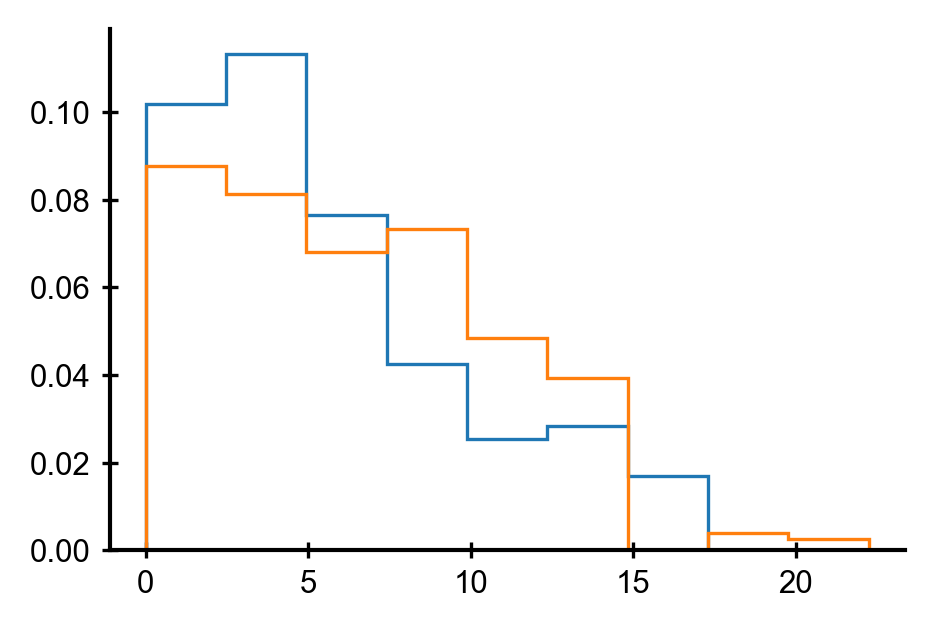

In [28]:
bins = np.linspace(0, distance.max(), 10)
plt.hist(distance[d1[('Assay', 'Positive')]], histtype='step', density=True, bins=bins)
plt.hist(distance[~d1[('Assay', 'Positive')]], histtype='step', density=True, bins=bins);

In [47]:
d1.columns = d1.columns.get_level_values(0)

In [56]:
import scipy.stats
scipy.stats.mannwhitneyu(distance[d1[('Assay')]], distance[~d1[('Assay')]], alternative='two-sided')

MannwhitneyuResult(statistic=19602.0, pvalue=0.05376475675961773)

In [30]:
cuts = pd.qcut(d1['distance'], 4)

In [31]:
dagg = d1.groupby(cuts).agg(['mean', 'count'])['Assay', 'Positive']
ps = np.asarray(list(dagg['mean']))
ns = np.asarray(dagg['count'])
ps, ns

/home/amayer/miniconda3/envs/min/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2867: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


(array([0.33628319, 0.38053097, 0.30973451, 0.23893805]),
 array([113, 113, 113, 113]))

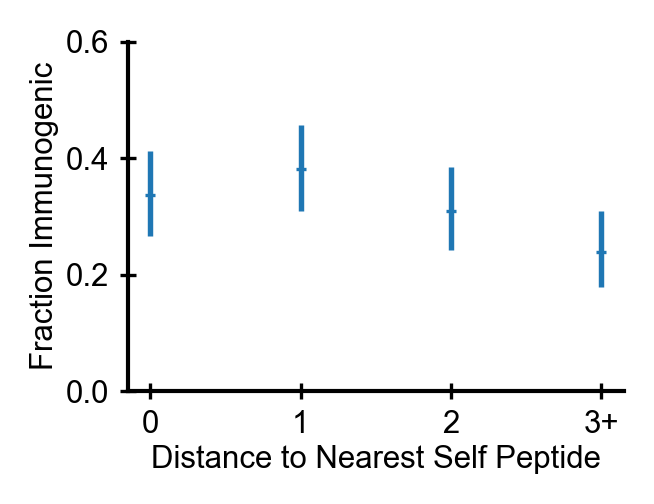

In [32]:
fig, ax = plt.subplots(figsize=(2.25, 1.75))
lower, upper = statsmodels.stats.proportion.proportion_confint(ps*ns, ns, method='jeffreys', alpha=.1)
ax.errorbar(range(len(ps)), ps, yerr=[ps-lower, upper-ps], ls='None', fmt='_')
ax.set_ylim(0.0, 0.6)
ax.set_xlabel('Distance to Nearest Self Peptide')
ax.set_ylabel('Fraction Immunogenic')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([0, 1, 2, '3+'])
fig.tight_layout()
fig.savefig(figuredir+'iedbposvsdist.svg')